# 2D Poisson problem

In [194]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.testproblem import FEniCSPoisson2D
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt

Print CUQIpy and CUQIpy-FEniCS versions:

In [195]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)

0+untagged.3467.g85645ce
0+untagged.260.g299ca7d


In [196]:
A = FEniCSPoisson2D(dim=(16,16), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Neumann', 'Dirichlet', 'Neumann']).model

In [197]:
G_domain = A.domain_geometry
G_range = A.range_geometry

In [198]:
# SMPrior class
class SMPrior:
    def __init__(self, ginv, corrlength, var, mean, covariancetype=None):
        self.corrlength = corrlength
        self.mean = mean
        self.c = 1e-9  # default value
        if covariancetype is not None:
            self.covariancetype = covariancetype
        else:
            self.covariancetype = 'Squared Distance'  # default
        self.compute_L(ginv, corrlength, var)

    def compute_L(self, g, corrlength, var):
        ng = g.shape[0]
        a = var - self.c
        b = np.sqrt(-corrlength**2 / (2 * np.log(0.01)))
        Gamma_pr = np.zeros((ng, ng))

        for ii in range(ng):
            for jj in range(ii, ng):
                dist_ij = np.linalg.norm(g[ii, :] - g[jj, :])
                if self.covariancetype == 'Squared Distance':
                    gamma_ij = a * np.exp(-dist_ij**2 / (2 * b**2))
                elif self.covariancetype == 'Ornstein-Uhlenbeck':
                    gamma_ij = a * np.exp(-dist_ij / corrlength)
                else:
                    raise ValueError('Unrecognized prior covariance type')
                if ii == jj:
                    gamma_ij = gamma_ij + self.c
                Gamma_pr[ii, jj] = gamma_ij
                Gamma_pr[jj, ii] = gamma_ij
        
        self.cov = Gamma_pr
        self.L = np.linalg.cholesky(np.linalg.inv(Gamma_pr)).T

    def draw_samples(self, nsamples):
        samples = self.mean + np.linalg.solve(self.L, np.random.randn(self.L.shape[0], nsamples))
        return samples

    def eval_fun(self, args):
        sigma = args[0]
        res = 0.5 * np.linalg.norm(self.L @ (sigma - self.mean))**2
        return res
    
    def evaluate_target_external(self, x, compute_grad=False):
        x = x.reshape((-1,1))
        # print("x.shape: ", x.shape)
        # print("self.mean.shape: ", self.mean.shape)
        if compute_grad:
            grad = self.L.T @ self.L @ (x - self.mean)
        else:
            grad = None
        
        return self.eval_fun(x), grad
        

    def compute_hess_and_grad(self, args, nparam):
        sigma = args[0]
        Hess = self.L.T @ self.L
        grad = Hess @ (sigma - self.mean)

        if nparam > len(sigma):
            Hess = np.block([[Hess, np.zeros((len(sigma), nparam - len(sigma)))],
                             [np.zeros((nparam - len(sigma), len(sigma))), np.zeros((nparam - len(sigma), nparam - len(sigma)))]])
            grad = np.concatenate([grad, np.zeros(nparam - len(sigma))])


        return Hess, grad

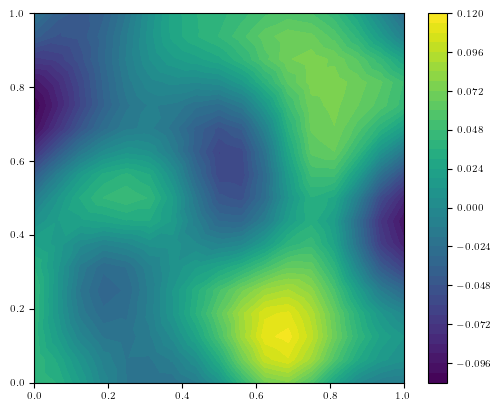

In [199]:

# Create correlation matrix for prior x

H = G_domain.function_space

v2d = dl.vertex_to_dof_map(H)
d2v = dl.dof_to_vertex_map(H)

mesh = G_domain.mesh 


mean_sigma = np.zeros((H.dim(), 1)) #linearization point
corrlength =  0.5
var_sigma = 0.05 ** 2   #prior variance

smprior = SMPrior(mesh.coordinates()[d2v], corrlength, var_sigma, mean_sigma)#, covariancetype='Ornstein-Uhlenbeck')


sample = smprior.draw_samples(1)
fun = dl.Function(H)
fun.vector().set_local(sample)
im = dl.plot(fun)
plt.colorbar(im)






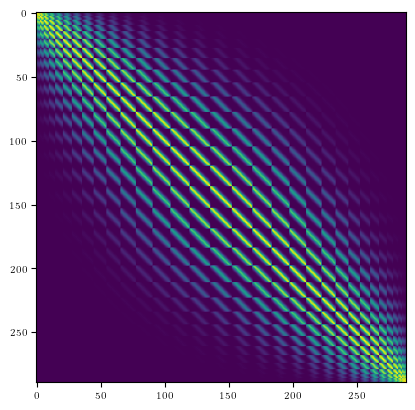

In [200]:
# visualize the covariance matrix 
plt.figure()
plt.imshow(smprior.cov)

In [201]:
x = Gaussian(np.zeros(G_domain.par_dim), cov=12*smprior.cov, geometry=G_domain)

In [202]:
# Set the random seed
np.random.seed(3) 

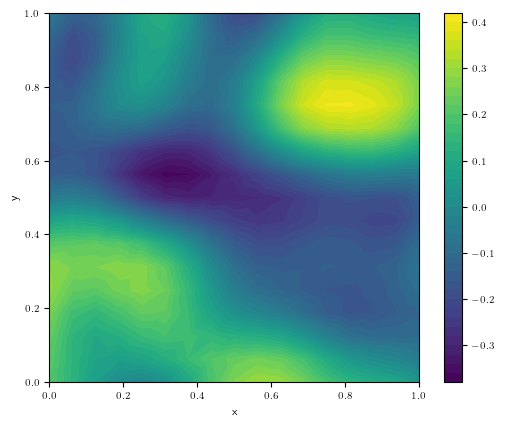

In [203]:
x_true = x.sample()
im = x_true.plot()
plt.colorbar(im[0])


This cell to compute s_noise

In [204]:
noise_level = 0.01
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_domain.par_dim)* noise_level*np.linalg.norm(y_true)

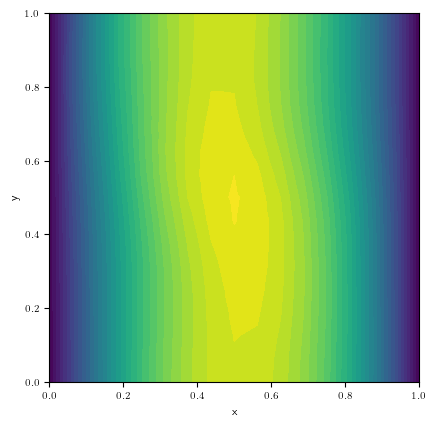

In [205]:
y_true.plot()

In [206]:
y = Gaussian(A(x), s_noise**2, geometry=G_range)

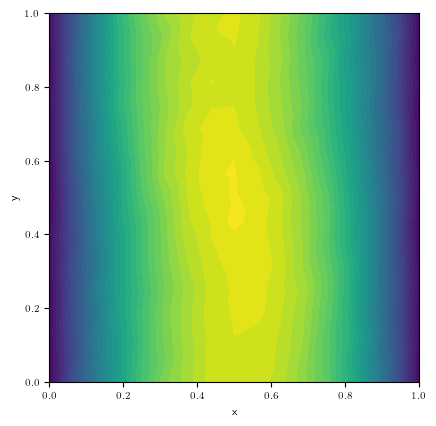

In [207]:
y_obs = y(x=x_true).sample()
y_obs.plot()

In [208]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

In [278]:
#posterior_samples = BP.UQ(Ns=3000, Nb=2, percent=97)
posterior = BP.posterior()
#sampler = cuqi.sampler.NUTS(posterior, max_depth=4, x0=np.zeros(G_domain.par_dim)+.001)
#sampler = cuqi.sampler.ULA(posterior, x0=np.zeros(G_domain.par_dim)+.001, scale=0.00000005)
# np.zeros(G_domain.par_dim)+.001

sampler = cuqi.experimental.mcmc.MH(posterior, initial_point=x_true.to_numpy(), scale=0.00005)
_ = sampler.warmup(100)
posterior_samples = sampler.get_samples()

#posterior_samples = sampler.sample_adapt(100, Nb=10)

Warmup: 100%|██████████| 100/100 [00:01<00:00, 62.92it/s, acc rate: 10.00%]


In [279]:
sampler.scale

2.521425624369591e-05

Code cell for generating Figure 1

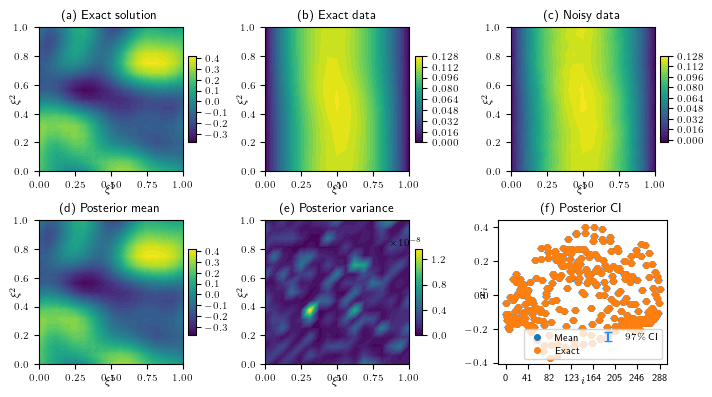

In [280]:
import os
from matplotlib import ticker
import matplotlib.pyplot as plt

# Set up matplotlib
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Use latex package
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

# Data directory
fig_dir = './figs/'

# Figure file
fig_dir = fig_dir 

# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Figure version
version = 'v8'

# Figure file
fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'

# Create the figure
cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3,
                        figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                        layout="constrained")

# Define the colors to be used in the plots
colors = ['C0', 'green', 'purple', 'k', 'gray']

# (a)
plt.sca(axs[0,0])
im = x_true.plot(subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('(a) Exact solution')
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5

# (b)
plt.sca(axs[0,1])
im = y_true.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(b) Exact data')

# (c)
plt.sca(axs[0,2])
im = y_obs.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(c) Noisy data')

# (d)
plt.sca(axs[1,0])
im = posterior_samples.plot_mean(
    subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(d) Posterior mean')

# (e)
plt.sca(axs[1,1])
im = posterior_samples.funvals.vector.plot_variance(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
cb.locator = ticker.MaxNLocator(nbins=4)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(e) Posterior variance')

# (f)
plt.sca(axs[1,2])
lci = posterior_samples.plot_ci(
    97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
lci[0].set_label("Mean")
lci[1].set_label("Exact")
lci[2].set_label("$97\\%$ CI")
#plt.ylim(-5, 3)
plt.legend(ncols=2) 
plt.ylabel(r'$\bm{x}_i$')
plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.set_label_coords( -0.06, 0.5)
plt.xlabel('$i$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(f) Posterior CI')
n_ticks = 8
num_var = posterior_samples.geometry.par_dim
tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
plt.xticks(tick_ids, tick_ids)

# Save the figure
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

In [270]:
posterior_samples.compute_ess()

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 10

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'x104'}>,
        <AxesSubplot: title={'center': 'x104'}>],
       [<AxesSubplot: title={'center': 'x139'}>,
        <AxesSubplot: title={'center': 'x139'}>],
       [<AxesSubplot: title={'center': 'x147'}>,
        <AxesSubplot: title={'center': 'x147'}>],
       [<AxesSubplot: title={'center': 'x269'}>,
        <AxesSubplot: title={'center': 'x269'}>],
       [<AxesSubplot: title={'center': 'x279'}>,
        <AxesSubplot: title={'center': 'x279'}>]], dtype=object)

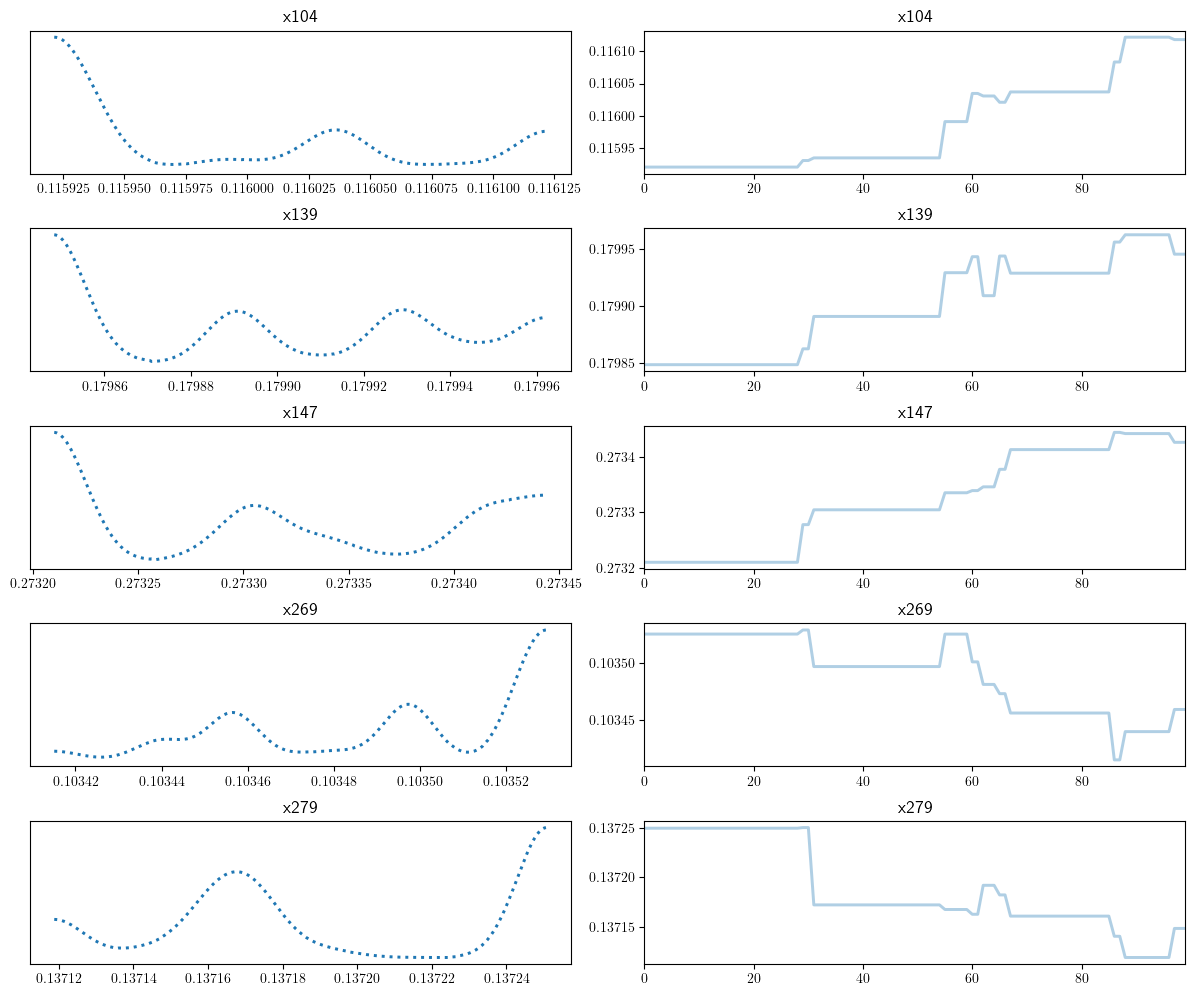

In [281]:
posterior_samples.plot_trace()


In [ ]:
posterior_samples.plot()

In [213]:
# 1D case 
# DG0
# TV with non-MY gradient and with NUTS 
# verify the gradient of the posterior
# PCN seems to work
# Start from x0=the true parameter to debug